In [1]:
%matplotlib inline
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

In [59]:
def theta_init(K):
    return(np.ones(K)/K)
def beta_ber_init(x,K):
    n,_ = x.shape
    return(np.ones((K,n))*0.5)
def beta_mean_sampleinit(x,K):
    n,_ = np.shape(x)
    i_sample = np.random.choice(list(range(n)),size=K, replace=False)
    x_sample = x[i_sample,:]
    return(x_sample)
def beta_sigma2_init(x,K):
    x_var = np.var(x)
    return(np.ones(K)*x_var/(K**2)*(st.uniform.rvs(0.5,1,size=K)))
def z_init(n,K):
    pre_z = st.multinomial.rvs(n=1,p=np.ones(K)/K,size=n)
    z_sample = np.array([np.where(pre_z[i,:]) for i in range(n)]).flatten()
    return(z_sample)

In [32]:
def theta_sample(z,alpha,K):
    n = len(z)
    dparams = np.ones(K)*alpha
    for i in range(n):
        dparams[z[i]] += 1
    theta_samp = st.dirichlet.rvs(dparams)
    return(theta_samp.flatten())

In [566]:
def beta_mean_sample_mn(x,z,beta_sigma2,gauss_mean_params):
    mu_0,sigma2_0 = gauss_mean_params
    mu_0 = np.array(mu_0)
    sigma2_0 = np.array(sigma2_0)
    n,D = np.shape(x)
    K,_ = np.shape(beta_sigma2)
    
    beta_mean_samp = np.zeros_like(beta_sigma2)
    for k in range(K):
        x_k = x[z==k]
        n_k = len(x_k)
        sigma2_k = beta_sigma2[k,:]
        
        #post_sigma2_k = np.linalg.inv(np.diag(1/sigma2_0)+np.diag(n_k/sigma2_k))
        post_sigma2_k = (np.diag(1/(1/sigma2_0+n_k/sigma2_k)))
        post_mu_k = np.dot(post_sigma2_k,((np.eye(D)/sigma2_0)@mu_0+(np.eye(D)/sigma2_k)@sum(x_k)))
        
        beta_mean_samp[k] = st.multivariate_normal.rvs(mean=post_mu_k,cov=(post_sigma2_k))
    return(beta_mean_samp)

In [28]:
def beta_bernoulli_sample(x,z,beta_hyper_params):
    alpha,beta = beta_hyper_params
    n,D = np.shape(x)
    K = int(max(z)+1)
    
    bernoulli_sample = np.zeros((K,D))
    
    for k in range(K):
        x_k = x[z==k]
        n_k = len(x_k)
        sum_k = np.sum(x_k,axis=0)

        bernoulli_sample[k,:] = st.beta.rvs(alpha+sum_k,beta+n_k-sum_k)
        
    return(bernoulli_sample)

In [119]:
def beta_mean_sample(x,z,beta_sigma2,gauss_mean_params):
    mu_0,sigma2_0 = gauss_mean_params
    n,D = np.shape(x)
    K,_ = np.shape(beta_sigma2)
    
    beta_mean_samp = np.zeros_like(beta_sigma2)
    for k in range(K):
        x_k = x[z==k]
        n_k = len(x_k)
        sigma2_k = beta_sigma2[k]
        
        post_sigma2_k = 1/(n_k/sigma2_k+1/sigma2_0)
        post_mu_k = post_sigma2_k*(mu_0/sigma2_0+sum(x_k)/sigma2_k)
        
        beta_mean_samp[k] = st.norm.rvs(loc=post_mu_k,scale=np.sqrt(post_sigma2_k))
    return(beta_mean_samp)

In [33]:
def z_sample(x,z,theta,beta_mean,beta_sigma2):
    n,D = np.shape(x)
    K = len(theta)
    
    log_prior = np.log(theta)
    log_likelihood = st.norm.logpdf(x.reshape((n,1)),
                                loc=beta_mean.reshape((1,K)),
                                scale = np.sqrt(beta_sigma2).reshape((1,K)))
    log_prob = log_prior+log_likelihood
    log_prob -= np.max(log_prob)
    prob = np.exp(log_prob)
    prob_norm = prob/np.sum(prob,axis=1).reshape((n,1))
    #[print(prob_norm[i,:]) for i in range(n)]
    
    z_samp = np.array([np.random.choice(list(range(K)),replace=True,
                                       p=prob_norm[i,:]) for i in range(n)])
    return(z_samp)

In [65]:
def z_sample_ber(x,z,theta,beta_bernoulli):
    n,D = np.shape(x)
    K = len(theta)
    
    log_prior = np.log(theta)
    log_likelihood = np.zeros((n,K))
    for k in range(K):
        log_likelihood[:,k] = np.sum(st.bernoulli.logpmf(x,p=beta_bernoulli[k,:]),axis = 1)
    log_prob = log_prior+log_likelihood
    log_prob -= np.max(log_prob)
    prob = np.exp(log_prob)
    prob_norm = prob/np.sum(prob,axis=1).reshape((n,1))
    z_samp = np.array([np.random.choice(list(range(K)),replace=True,
                                       p=prob_norm[i,:]) for i in range(n)])
    return(z_samp)

In [319]:
def z_sample_mn(x,z,theta,beta_mean,beta_sigma2):
    n,D = np.shape(x)
    K = len(theta)
    
    log_prior = np.log(theta)
    log_likelihood = np.zeros((n,K))
    for k in range(K):
        log_likelihood[:,k] = st.multivariate_normal.logpdf(x,
                         mean=beta_mean[k,:],cov=np.diag(beta_sigma2[k,:]))
    log_prob = log_prior+log_likelihood
    log_prob -= np.max(log_prob)
    prob = np.exp(log_prob)
    prob_norm = prob/np.sum(prob,axis=1).reshape((n,1))
    #[print(prob_norm[i,:]) for i in range(n)]
    
    z_samp = np.array([np.random.choice(list(range(K)),replace=True,
                                       p=prob_norm[i,:]) for i in range(n)])
    return(z_samp)

In [221]:
def gibbs_sampler(data, cat_num,hyper_theta,hyper_mean,hyper_sigma2,T=5e2):
    n,D = np.shape(data)
    x = data
    K = cat_num
    T = int(T)
    
    theta_stored = np.zeros((K,T))
    beta_mean_stored = np.zeros((K,T))
    beta_sigma2_stored = np.zeros((K,T))
    z_stored = np.zeros((n,T))
    theta = theta_init(K)
    beta_mean = beta_mean_sampleinit(x,K)
    beta_sigma2 = np.ones(K)
    z = z_init(n,K)
    log_p = np.zeros(T)
    
    for t in range(T):
        theta = theta_sample(z,hyper_theta,K)
        #print(theta.shape)
        theta_stored[:,t] = theta
        beta_mean = beta_mean_sample(x,z,beta_sigma2,hyper_mean)
        beta_mean_stored[:,t] = beta_mean
        z = z_sample(x,z,theta,beta_mean,beta_sigma2)
        z_stored[:,t] = z
        #log_p[t] = log_joint(x,z,beta_mean,beta_sigma2,theta,hyper_theta,
                           # hyper_mean,hyper_sigma2)
    
    #plt.plot(log_p)
    
    return({'z':z_stored, 'theta':theta_stored, 'beta_mean':beta_mean_stored})
        

In [71]:
def gibbs_sampler_ber(data, cat_num,hyper_theta,hyper_mean,T=5e2,plot=False,
                    full = False):
    try:
        n,D = np.shape(data)
    except ValueError:
        n = len(data)
        D = 1
    x = data
    K = cat_num
    T = int(T)
    
    if full:
        theta_stored = np.zeros((K,T))
        beta_ber_stored = np.zeros((K,D,T))
        z_stored = np.zeros((n,T))
    theta = theta_init(K)
    beta_ber = beta_ber_init(x,K)
    z = z_init(n,K)
    if plot:
        log_p = np.zeros(T)
    
    for t in range(T):
        theta = theta_sample(z,hyper_theta,K)
        beta_ber = beta_bernoulli_sample(x,z,hyper_mean)
        z = z_sample_ber(x,z,theta,beta_ber)
        
        if full:
            theta_stored[:,t] = theta
            beta_ber_stored[:,:,t] = beta_ber
            z_stored[:,t] = z
        if plot:
            log_p[t] = log_joint_ber(data,theta,z,beta_ber,hyper_theta,hyper_mean)
                 # log_joint(data,theta,z,beta_mean,beta_sigma,theta_p,beta_mean_p,beta_sigma_p)
    
    if plot:
        print(log_p)
        plt.plot(log_p)
        plt.title("log joint probability")
        plt.xlabel('iterations')
        plt.ylabel('log joint probability')
        #plt.yscale('symlog')
        plt.show()
    if full:
        return({'z':z_stored, 'theta':theta_stored, 'beta_ber':beta_ber_stored})
    else:
        return({'z':z,'theta':theta,'beta_ber':beta_ber})

In [675]:
def gibbs_sampler_mn(data, cat_num,hyper_theta,hyper_mean,hyper_sigma2,T=5e2,plot=False,
                    full = False):
    try:
        n,D = np.shape(data)
    except ValueError:
        n = len(data)
        D = 1
    x = data
    K = cat_num
    T = int(T)
    
    theta_stored = np.zeros((K,T))
    beta_mean_stored = np.zeros((K,D,T))
    beta_sigma2_stored = np.zeros((K,D,T))
    z_stored = np.zeros((n,T))
    theta = theta_init(K)
    beta_mean = beta_mean_sampleinit(x,K)
    beta_sigma2 = np.ones((K,D))
    z = z_init(n,K)
    if plot:
        log_p = np.zeros(T)
    
    for t in range(T):
        theta = theta_sample(z,hyper_theta,K)
        
        beta_mean = beta_mean_sample_mn(x,z,beta_sigma2,hyper_mean)
        
        z = z_sample_mn(x,z,theta,beta_mean,beta_sigma2)
        
        if full:
            theta_stored[:,t] = theta
            beta_mean_stored[:,:,t] = beta_mean
            z_stored[:,t] = z
        if plot:
            log_p[t] = log_joint(data,theta,z,beta_mean,beta_sigma2,hyper_theta,hyper_mean,hyper_sigma2)
                 # log_joint(data,theta,z,beta_mean,beta_sigma,theta_p,beta_mean_p,beta_sigma_p)
    
    if plot:
        print(log_p)
        plt.plot(log_p)
        plt.title("log joint probability")
        plt.xlabel('iterations')
        plt.ylabel('log joint probability')
        #plt.yscale('symlog')
        plt.show()
    if full:
        return({'z':z_stored, 'theta':theta_stored, 'beta_mean':beta_mean_stored})
    else:
        return({'z':z,'theta':theta,'beta_mean':beta_mean})

In [510]:
def log_joint(data,theta_s,z_s,beta_mean_s,beta_sigma_s,theta_p,beta_mean_p,beta_sigma_p):
    try:
        n,D = np.shape(data)
    except ValueError:
        n = len(data)
        D = 1
    x = data
    K = len(theta_s)
    
    #print(theta_s.shape,theta_p.shape)
    log_prior_dir = st.dirichlet.logpdf(theta_s,theta_p)
    z_s_1vec = np.zeros((n,K))
    z_s = np.array(z_s,dtype=int)
    z_s_1vec[np.arange(n),z_s] = 1
    log_prior_z = st.multinomial.logpmf(z_s_1vec,1,theta_s)
    log_prior_gau = np.sum(st.multivariate_normal.logpdf(beta_mean_s,
                                                  mean=beta_mean_p[0],cov=beta_mean_p[1]))
    result = log_prior_dir+log_prior_gau
    
    #for i in range(n):
    #    result += np.log(theta_s[z_s[i]])+st.multivariate_normal.logpdf(x[i,:],mean=beta_mean_s[z_s[i],:])
    
    for k in range(K):
        x_k = x[z_s==k,:]
        result += np.sum(theta_s[k]+st.multivariate_normal.logpdf(x[z_s==k,:],mean=beta_mean_s[k,:]))
    
    return(result)
    
    

In [105]:
def log_joint_ber(data,theta_s,z_s,beta_ber_s,theta_p,beta_ber_p):
    try:
        n,D = np.shape(data)
    except ValueError:
        n = len(data)
        D = 1
    x = data
    K = len(theta_s)
    
    #print(theta_s.shape,theta_p.shape)
    log_prior_dir = st.dirichlet.logpdf(theta_s,theta_p)
    z_s_1vec = np.zeros((n,K))
    z_s = np.array(z_s,dtype=int)
    z_s_1vec[np.arange(n),z_s] = 1
    log_prior_z = st.multinomial.logpmf(z_s_1vec,1,theta_s)
    log_prior_ber = np.sum(st.beta.logpdf(beta_ber_s,beta_ber_p[0],beta_ber_p[1]))
    #print(log_prior_ber)
    #print("=====================")
    #print("beta_bernoulli_sample")
    #print(str(beta_ber_s))
    #print("beta_bernoulli_parameters")
    #print(str(beta_ber_p))
    #log_prior_gau = np.sum(st.multivariate_normal.logpdf(beta_mean_s,
                                                  #mean=beta_mean_p[0],cov=beta_mean_p[1]))
    result = log_prior_dir+log_prior_ber
    
    #for i in range(n):
    #    result += np.log(theta_s[z_s[i]])+st.multivariate_normal.logpdf(x[i,:],mean=beta_mean_s[z_s[i],:])
    
    for k in range(K):
        x_k = x[z_s==k,:]
        result += np.sum(theta_s[k]+np.sum(st.bernoulli.logpmf(x[z_s==k,:],p=beta_ber_s[k,:]),axis = 1))
        
    
    return(result)
    
    

In [86]:
import pandas as pd
senate_data = pd.read_csv('votes.csv')
vote_data = senate_data.values
n1,n2 = vote_data.shape
for i in range(n1):
    for j in range(n2):
        if vote_data[i,j] == -1:
            vote_data[i,j] = 0.5
u,d,vt = np.linalg.svd(vote_data.T@vote_data)
v=vt.T
new_vote_data = vote_data@u[:,:2]


## Here we do the Beta-Bernoulli Mixture model

[-38701.68585545 -18440.47306139 -17946.26236231 -17932.17191512
 -17899.18773276 -17970.26881164 -18017.79423278 -17999.67493763
 -17882.89347028 -17922.93900811 -17993.38246039 -17984.92154665
 -18000.73162824 -18018.26677064 -18064.80341417 -17927.41488296
 -17966.16728671 -17899.87491166 -18047.44553781 -17978.48693261
 -17970.04085161 -17973.23713864 -17951.92511974 -17991.0215418
 -17940.09162339 -17948.57045349 -17968.281325   -17997.70234815
 -18002.42428829 -17986.31332865 -17963.72120827 -17999.99100426
 -17940.21667802 -17984.02929673 -17984.26103187 -17969.90137865
 -17913.16005868 -17877.14280091 -17946.7554834  -17954.43547752
 -18011.63918664 -17995.2494601  -17963.02172432 -17970.91286788
 -17963.99466979 -17971.59474074 -17952.74907252 -17948.57209502
 -17919.2002971  -17966.77390833 -17984.77931016 -17934.33496491
 -17958.50935293 -17943.44654008 -17992.26903265 -18024.08081067
 -18014.37871483 -17993.30614431 -18006.55845055 -18042.82282509
 -17954.7596326  -17968.18

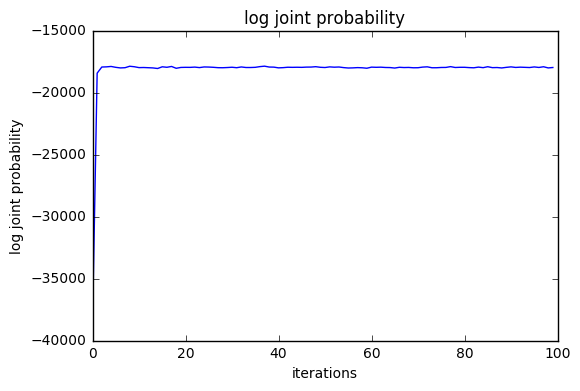

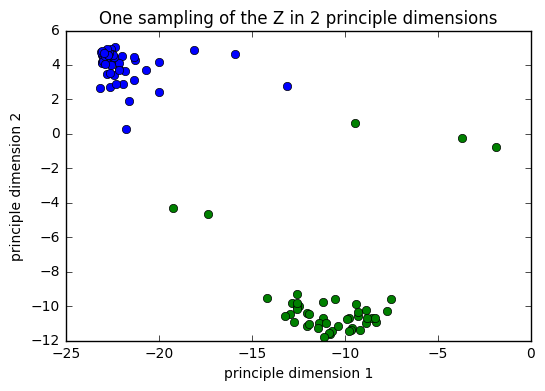

In [106]:
#%debug
results_i = gibbs_sampler_ber(vote_data, 2, 0.5*np.ones(2),(0.5*np.ones(n2),0.5*np.ones(n2)),T=100,plot=True)
K=2
for k in range(K):
    plt.plot(new_vote_data[:,0][results_i['z']==k],new_vote_data[:,1][results_i['z']==k],'o',label=str(k))

    
plt.title("One sampling of the Z in 2 principle dimensions")
plt.xlabel('principle dimension 1')
plt.ylabel('principle dimension 2')
plt.show()

In [108]:
#%debug
gibbs_n = 1000
clusters_n = 2
z_sampled = np.zeros((gibbs_n,n1))
theta_sampled = np.zeros((gibbs_n,clusters_n))
beta_ber_sampled = np.zeros((gibbs_n,clusters_n,n2))
sampled_params = {'z':z_sampled,
                  'theta':theta_sampled,
                  'beta_ber':beta_ber_sampled}
i = 0
while i != gibbs_n:
    try:
        results_i = gibbs_sampler_ber(vote_data, 2, 0.5*np.ones(2),
                                (0.5*np.ones(n2),0.5*np.ones(n2)),T=10,plot=False,full=True)
        #results_i = gibbs_sampler_ber(vote_data, clusters_n, np.ones(clusters_n),
                                     #(np.zeros(n2),np.ones(n2)),(h_ig1,h_ig2),T=10)
        sampled_params['z'][i,:] = results_i['z'][:,-1]
        sampled_params['theta'][i,:] = results_i['theta'][:,-1]
        sampled_params['beta_ber'][i,:,:] = results_i['beta_ber'][:,:,-1]
        i+=1
    except ValueError:
        pass
        

Below is the posterior for the Bernoulli's mean.

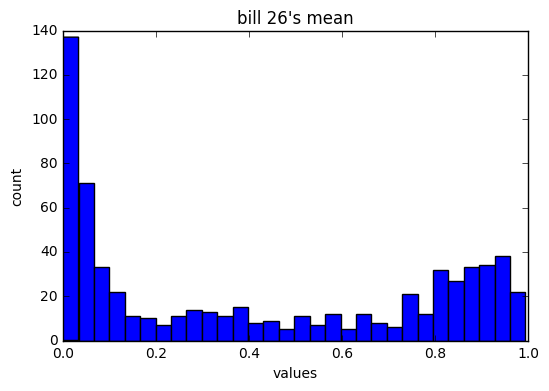

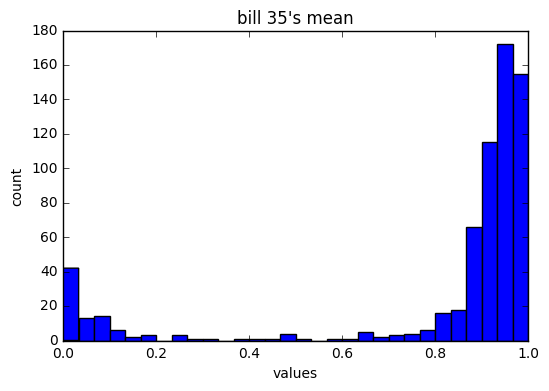

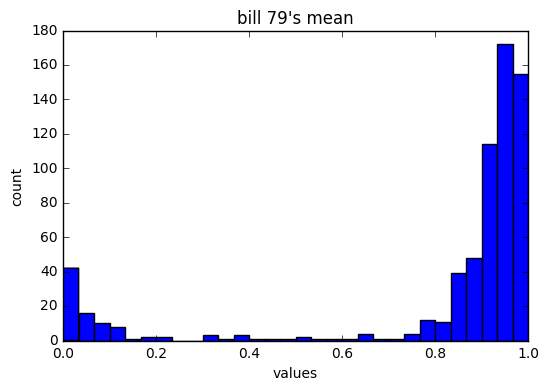

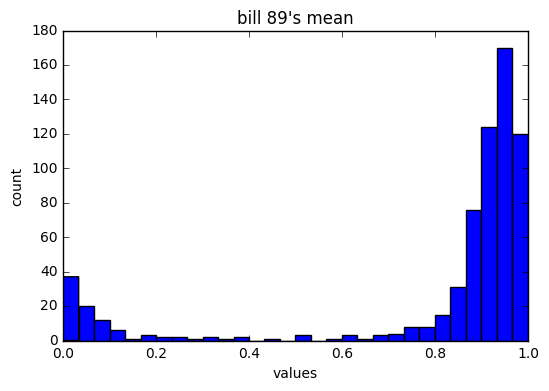

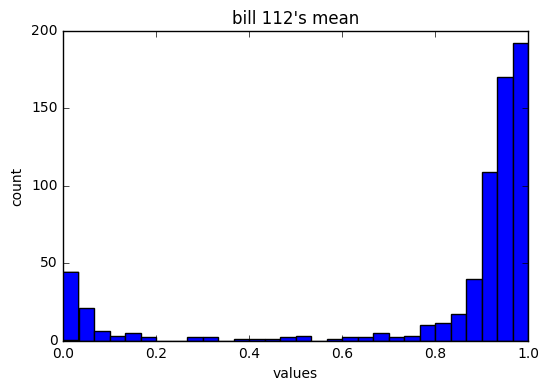

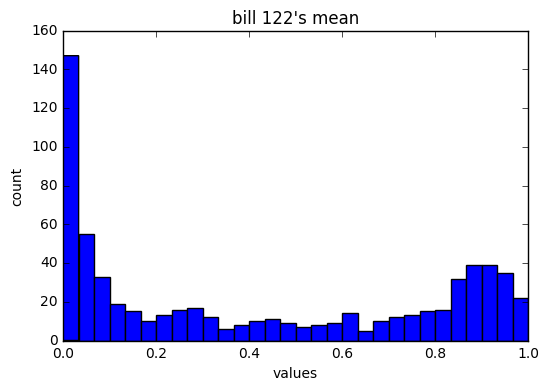

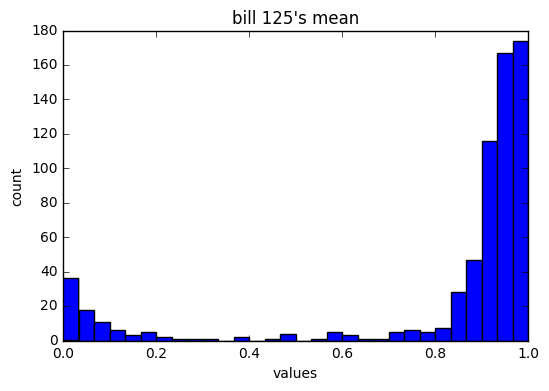

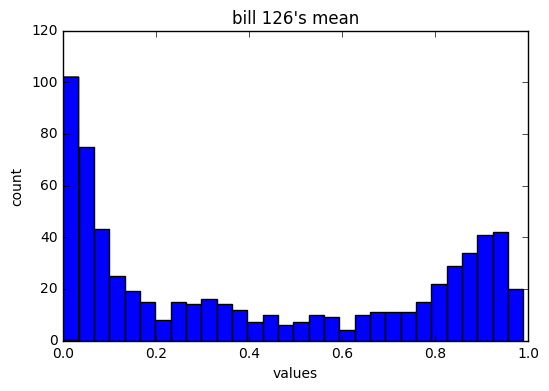

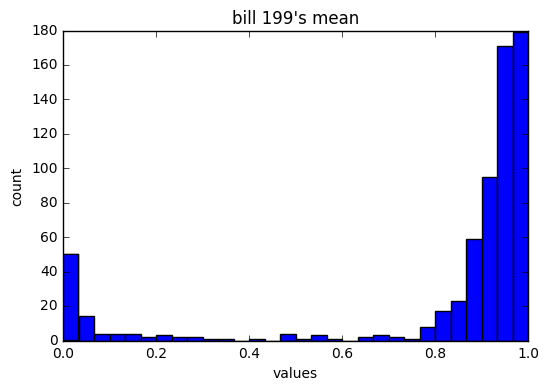

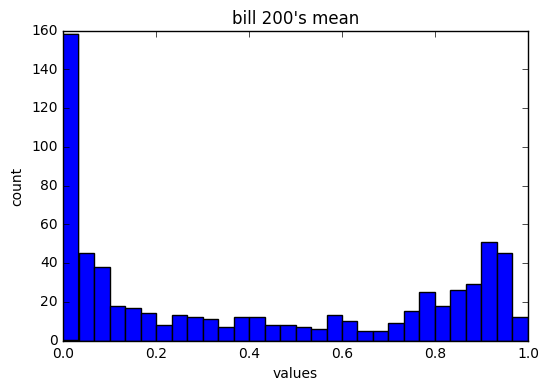

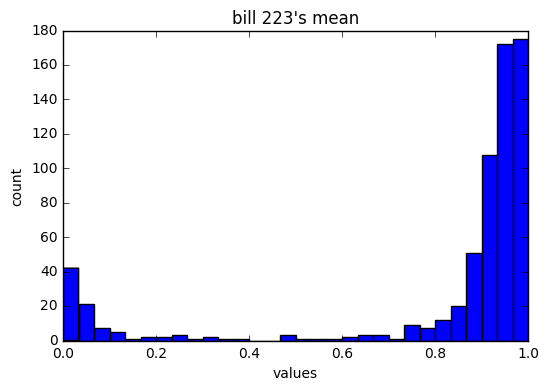

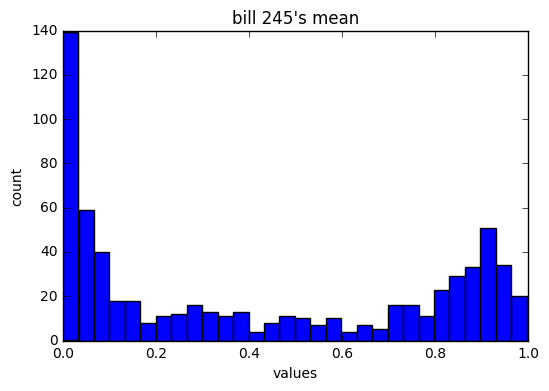

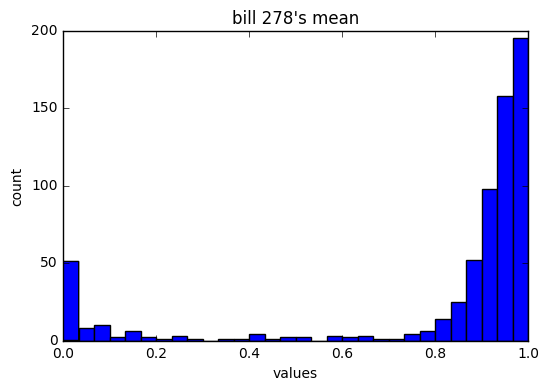

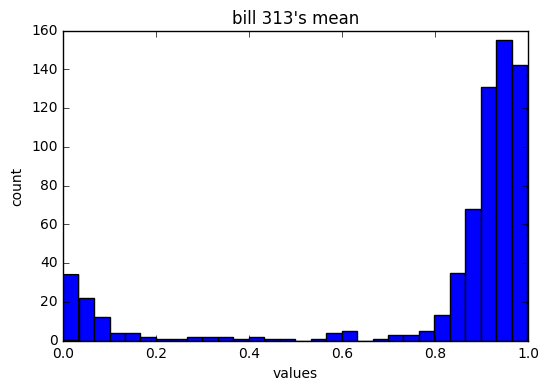

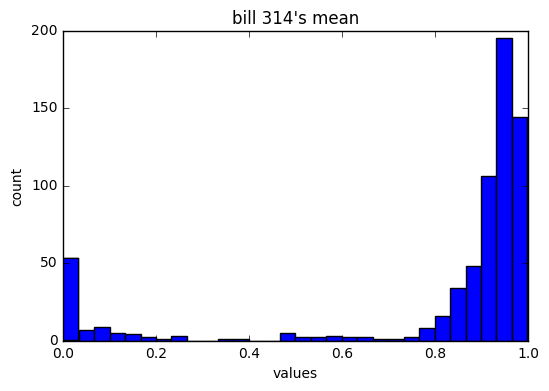

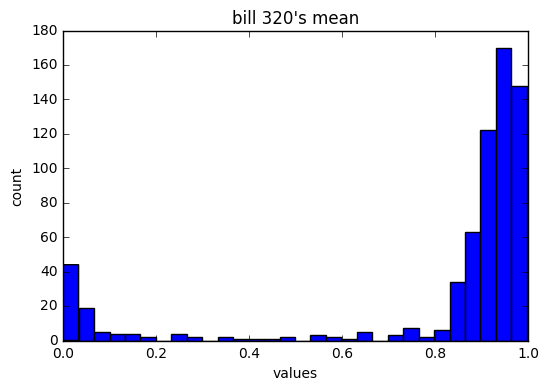

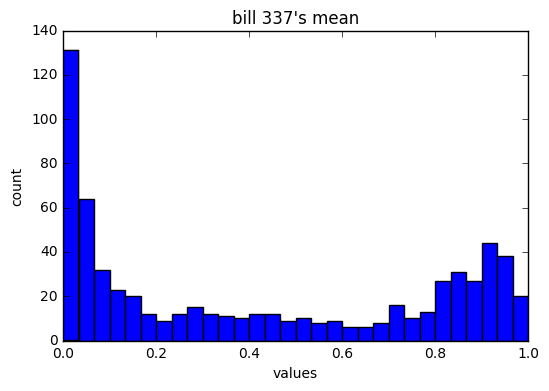

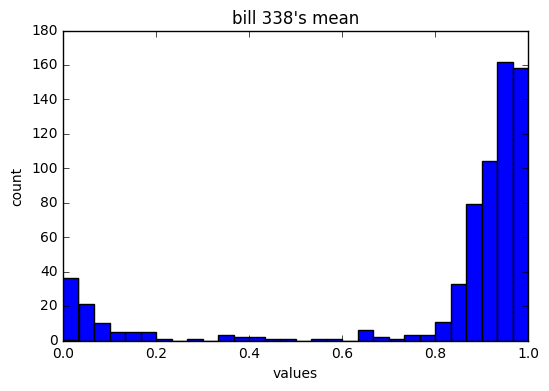

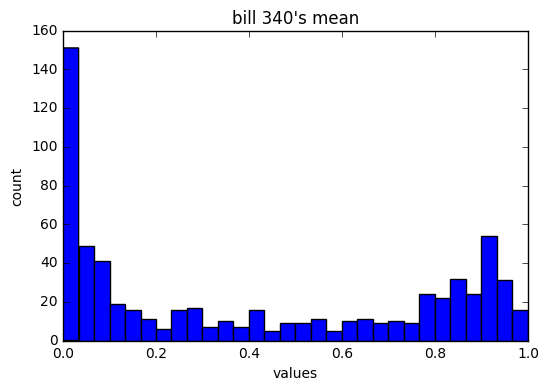

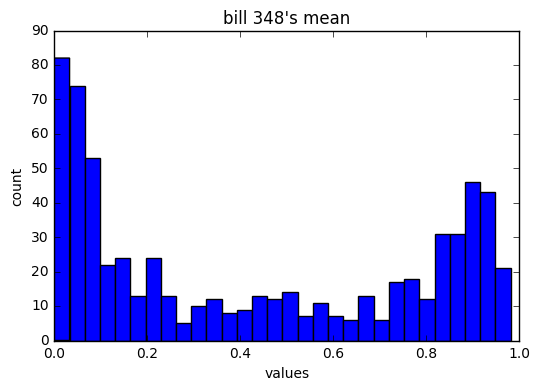

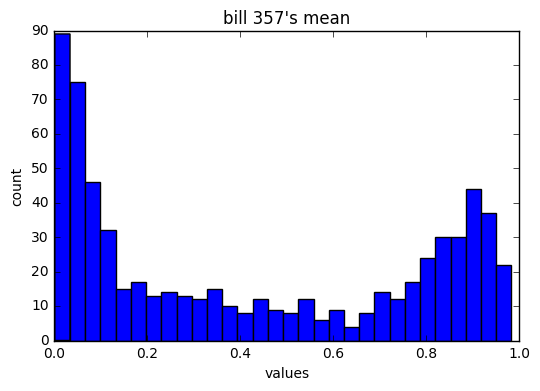

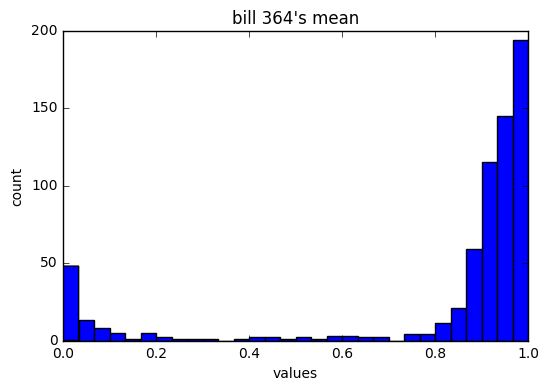

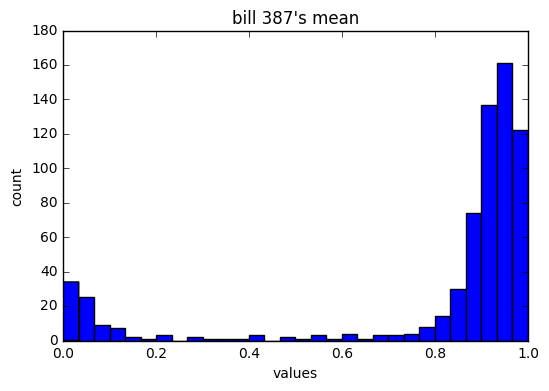

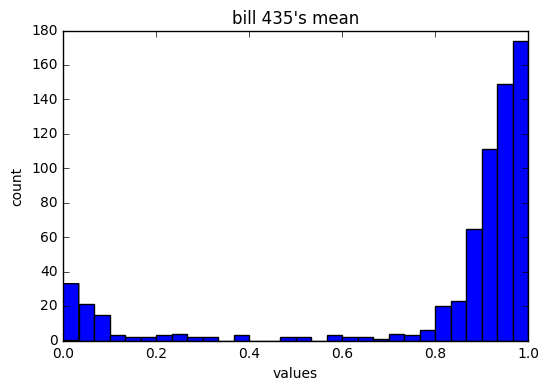

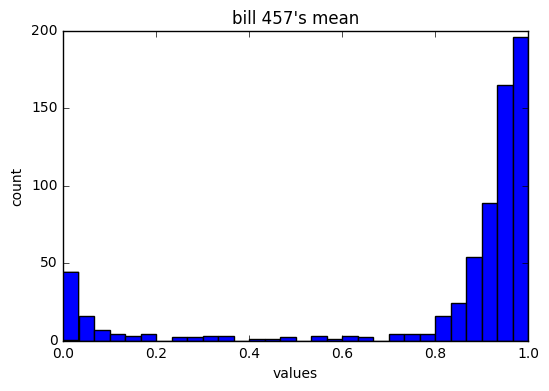

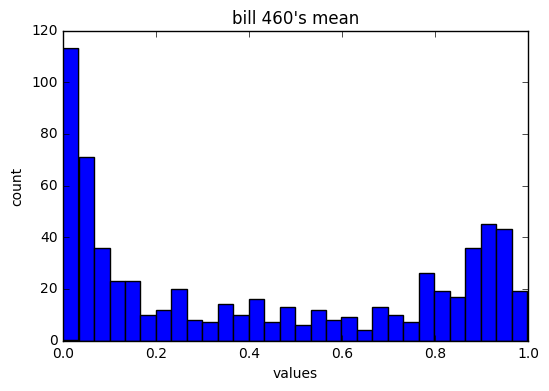

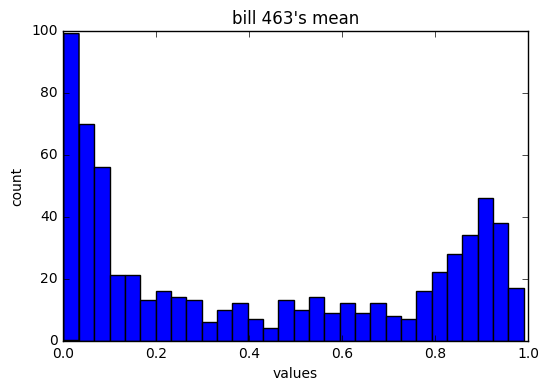

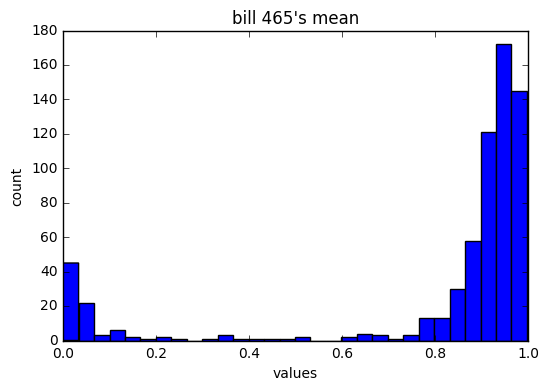

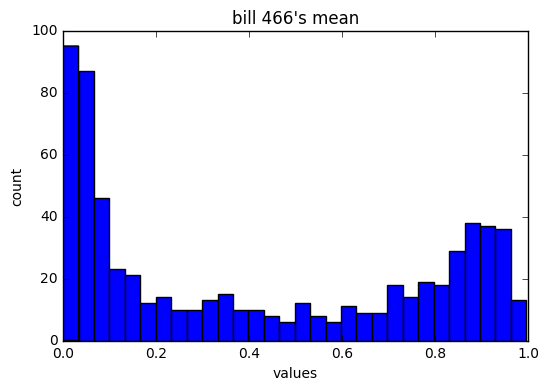

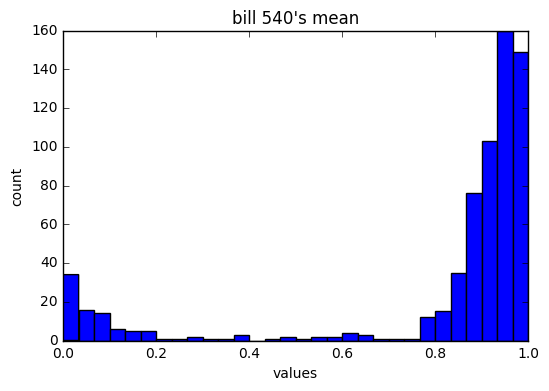

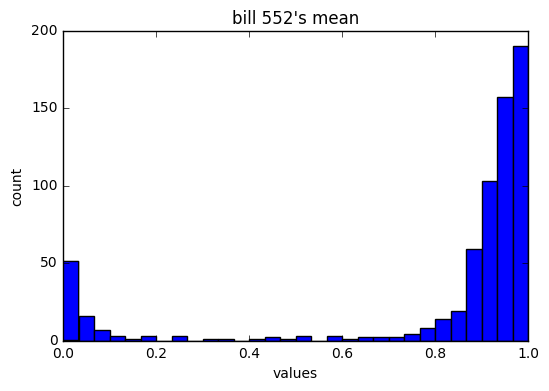

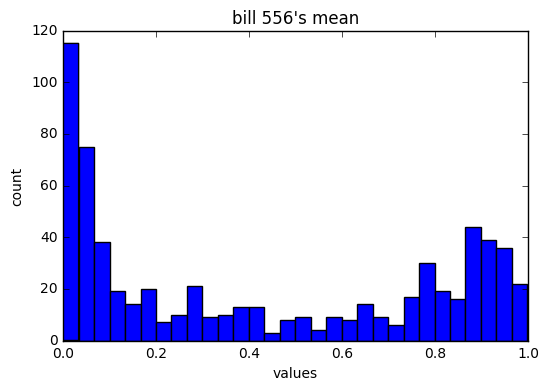

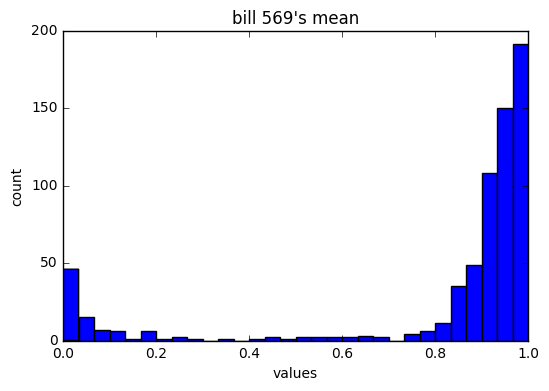

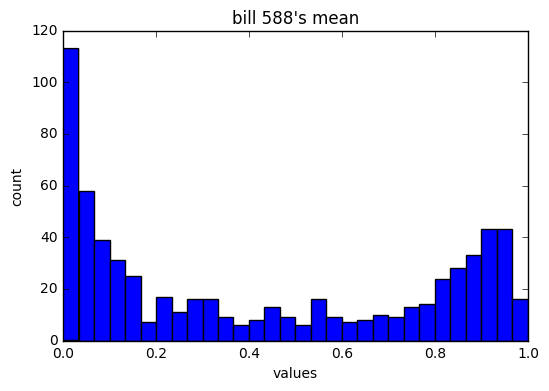

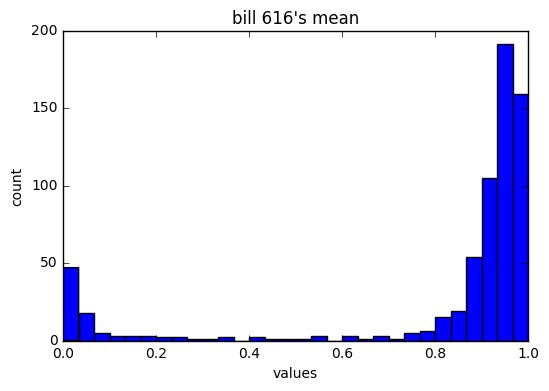

In [109]:
for i in range(n2):
    if st.uniform.rvs()<0.05:
        plt.hist(sampled_params['beta_ber'][i,0,:],bins=30)
        plt.title('bill '+str(i)+"'s mean")
        plt.ylabel('count')
        plt.xlabel('values')
        plt.show()

## Below we do the Gaussian Mixture model

In [661]:
#%debug
gibbs_n = 1000
clusters_n = 2
z_sampled = np.zeros((gibbs_n,n1))
theta_sampled = np.zeros((gibbs_n,clusters_n))
beta_mean_sampled = np.zeros((gibbs_n,clusters_n,n2))
sampled_params = {'z':z_sampled,
                  'theta':theta_sampled,
                  'beta_mean':beta_mean_sampled}
i = 0
while i != gibbs_n:
    try:
        results_i = gibbs_sampler_mn(vote_data, clusters_n, np.ones(clusters_n),
                                     (np.zeros(n2),np.ones(n2)),(h_ig1,h_ig2),T=10)
        sampled_params['z'][i,:] = results_i['z'][:,-1]
        sampled_params['theta'][i,:] = results_i['theta'][:,-1]
        sampled_params['beta_mean'][i,:,:] = results_i['beta_mean'][:,:,-1]
        i+=1
    except ValueError:
        pass
        

[-145536.09284863 -141986.04152093 -141994.33113047 -141924.33865338
 -141956.91118802 -141919.55708348 -141893.28320205 -141954.33708427
 -141903.59734964 -141960.28773754 -141921.95033178 -141948.11024697
 -141915.43298449 -141978.87627183 -141925.85481245 -141896.41183097
 -141944.73271932 -141937.87483605 -141926.93409574 -141943.11183685
 -141908.47834223 -141946.9895654  -141909.13419323 -141945.53074538
 -141905.1821803  -141986.58940417 -141935.09929289 -141952.40334131
 -141977.76757711 -141911.28882823 -141930.0901411  -141973.73518621
 -141885.09807851 -141925.30103099 -141932.96617197 -141962.32906534
 -141962.43597738 -141950.78772158 -141926.5660418  -141922.32980395
 -141973.80639898 -141917.35872295 -141917.93969346 -141913.07726262
 -141960.942116   -141946.25020526 -141933.50932376 -141934.68839849
 -141905.6925334  -142018.05046133 -141945.64929924 -141932.55467173
 -141983.02810642 -141923.07034646 -141909.40319085 -141915.80419463
 -141944.66577818 -141942.47098553

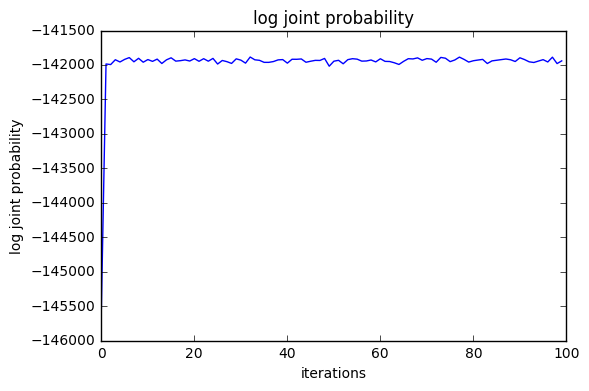

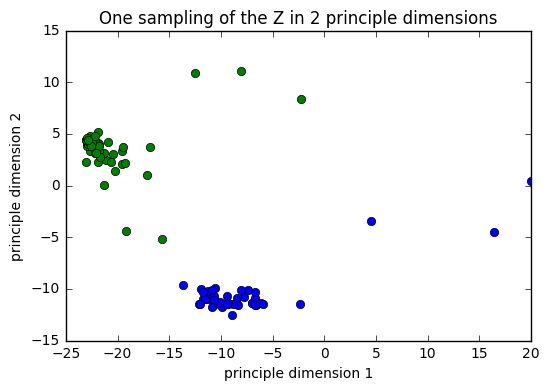

In [553]:
results_i = gibbs_sampler_mn(vote_data, 2, np.ones(2),(np.zeros(n2)-10,np.ones(n2)),(h_ig1,h_ig2),T=100,plot=True)
K=2
for k in range(K):
    plt.plot(new_vote_data[:,0][results_i['z'][:,-1]==k],new_vote_data[:,1][results_i['z'][:,-1]==k],'o',label=str(k))

    
plt.title("One sampling of the Z in 2 principle dimensions")
plt.xlabel('principle dimension 1')
plt.ylabel('principle dimension 2')
plt.show()

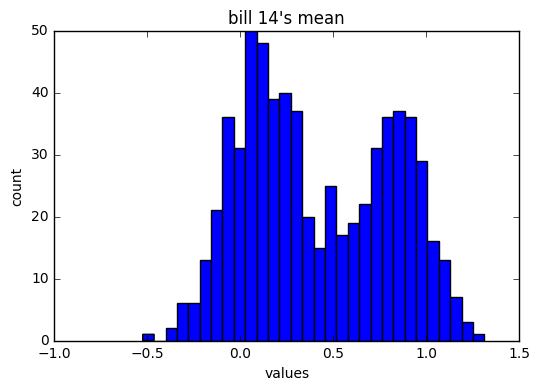

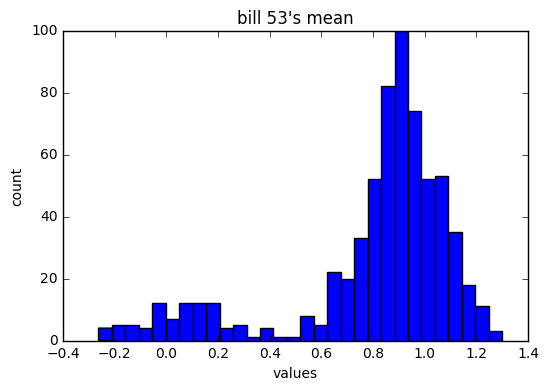

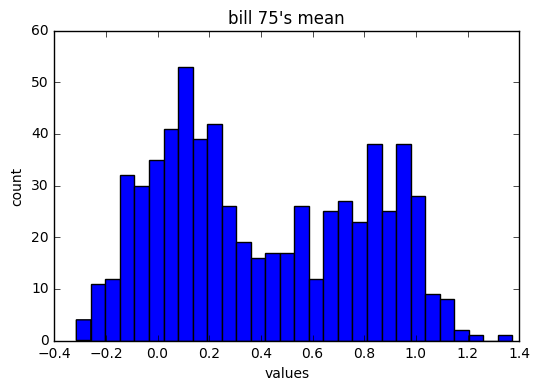

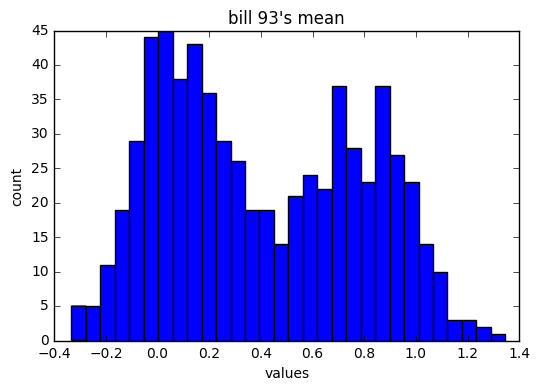

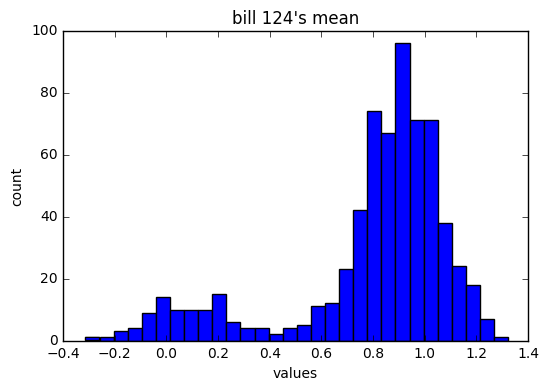

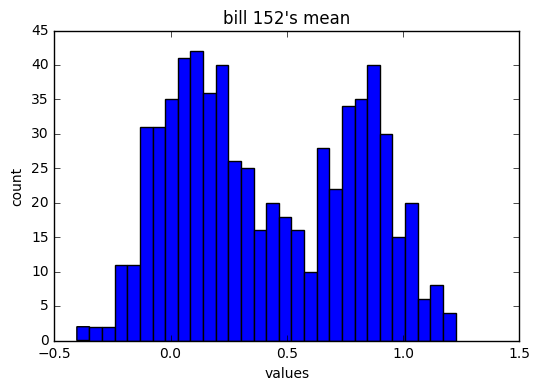

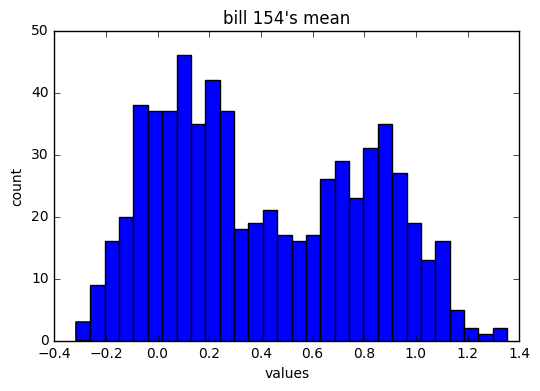

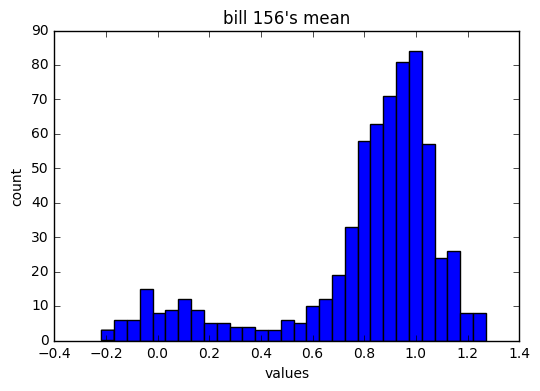

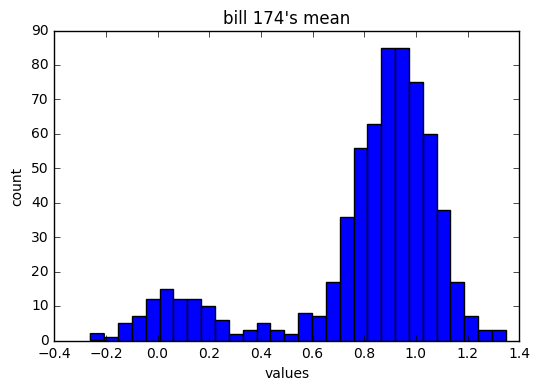

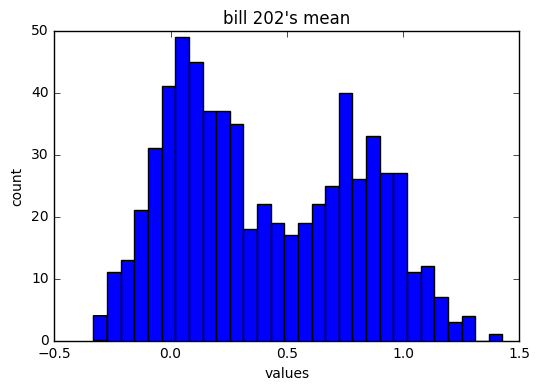

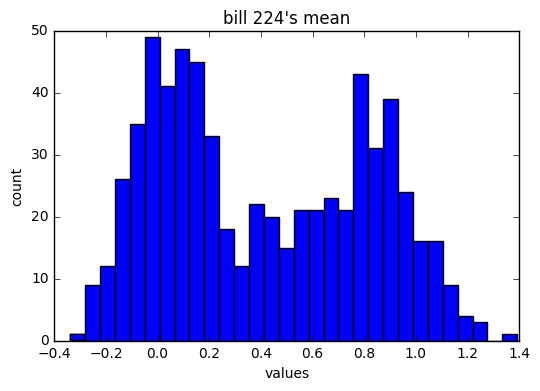

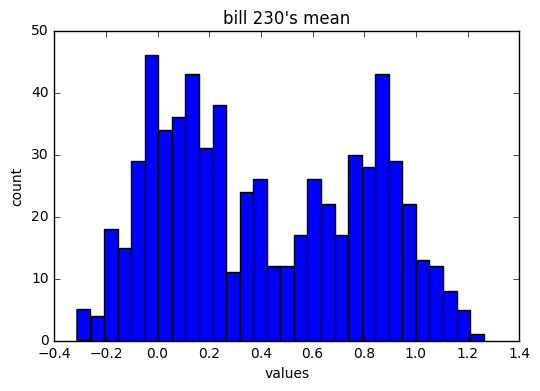

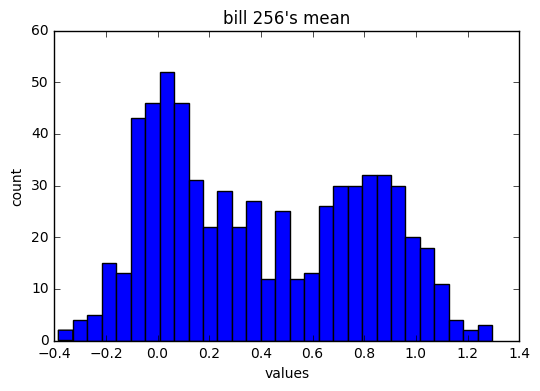

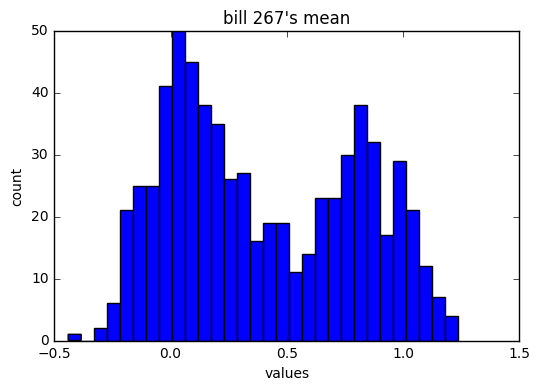

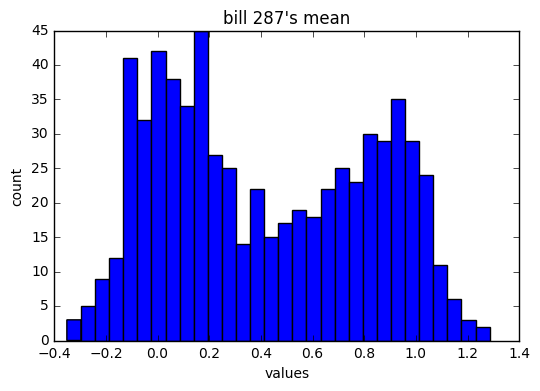

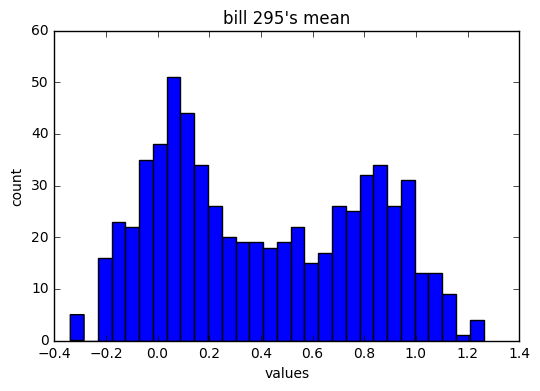

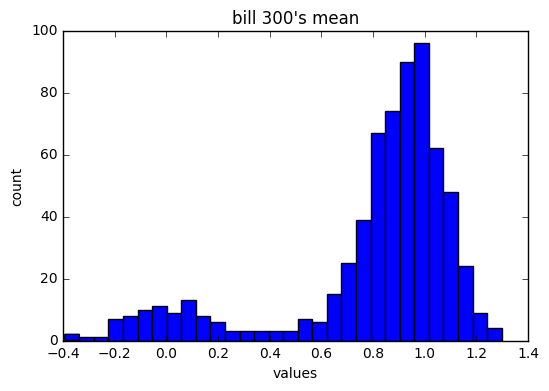

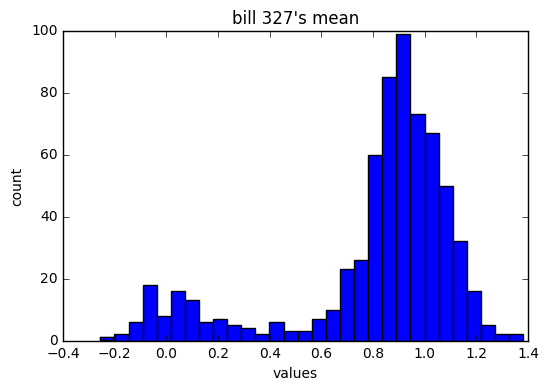

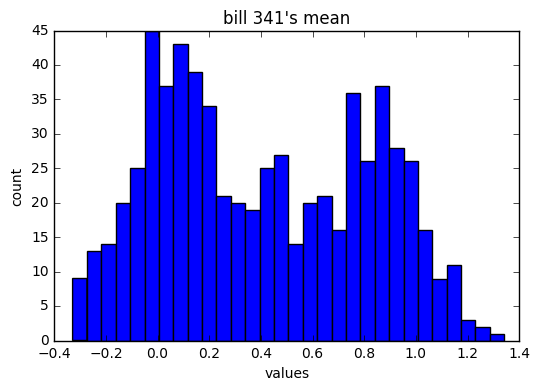

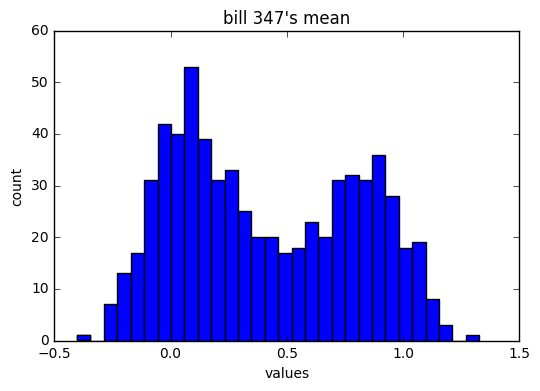

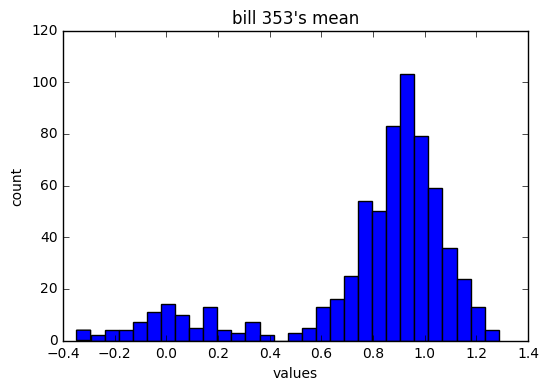

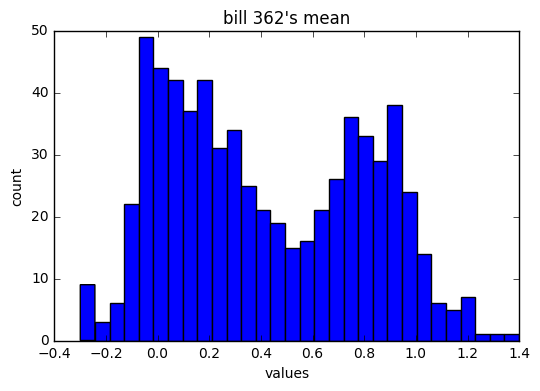

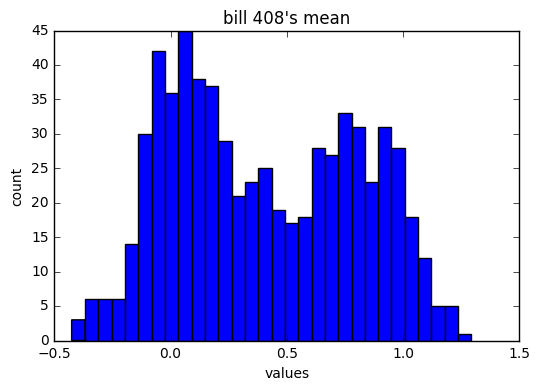

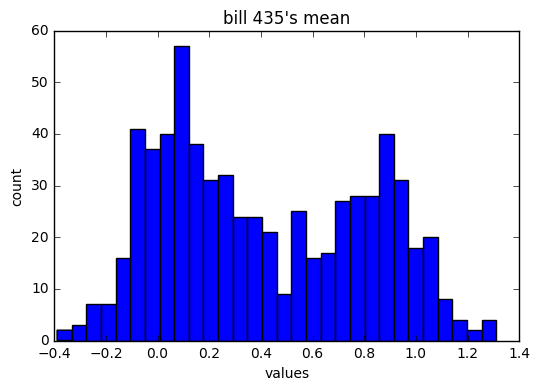

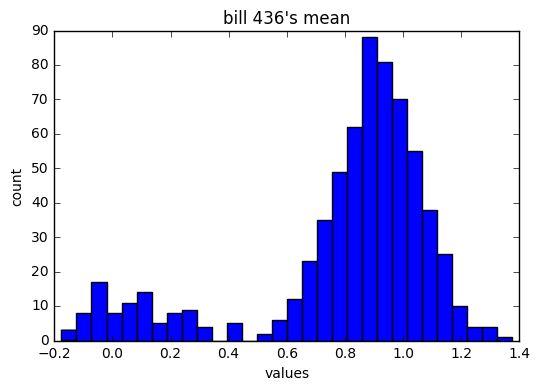

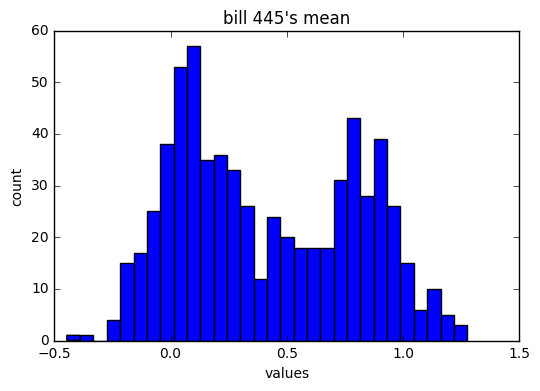

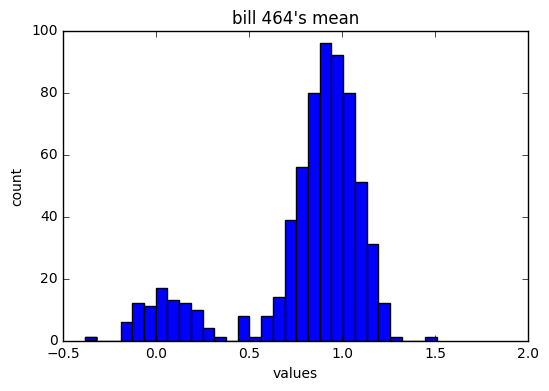

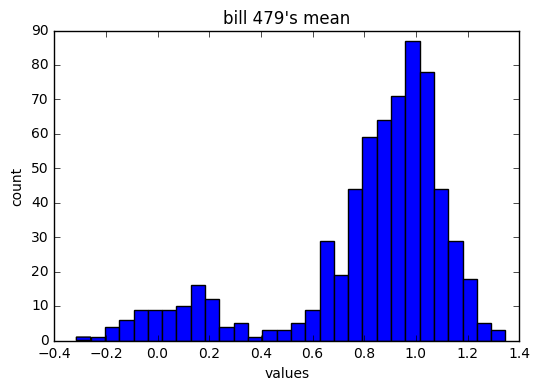

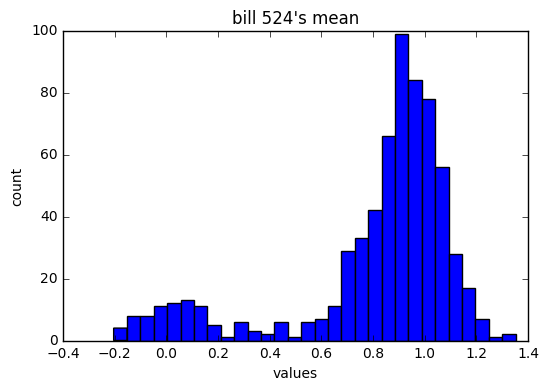

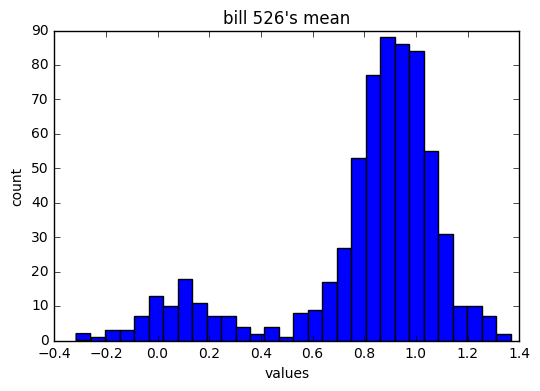

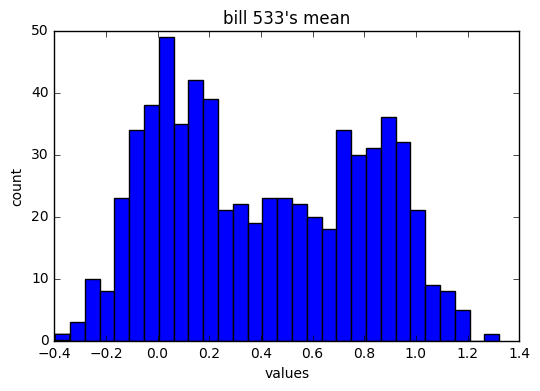

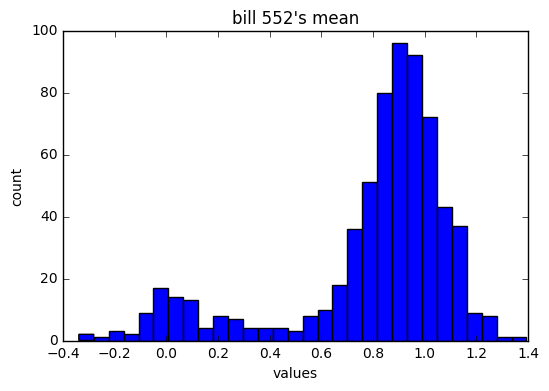

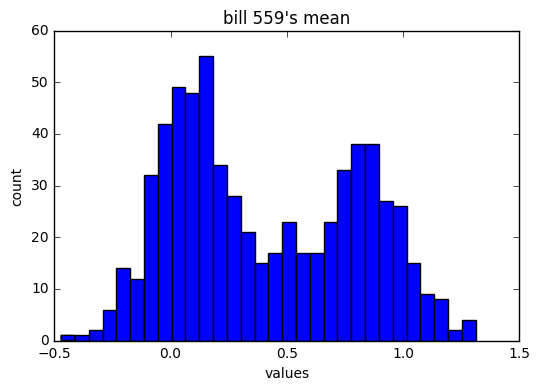

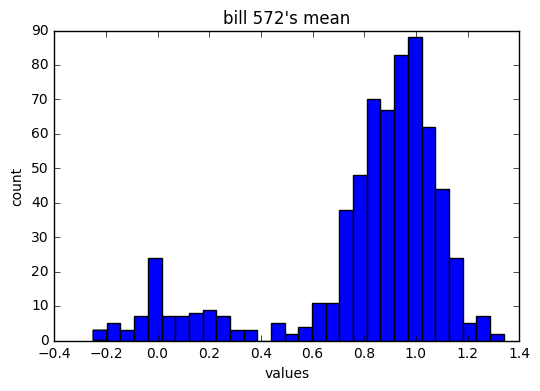

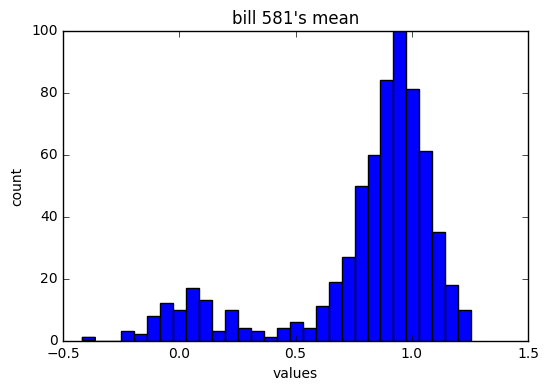

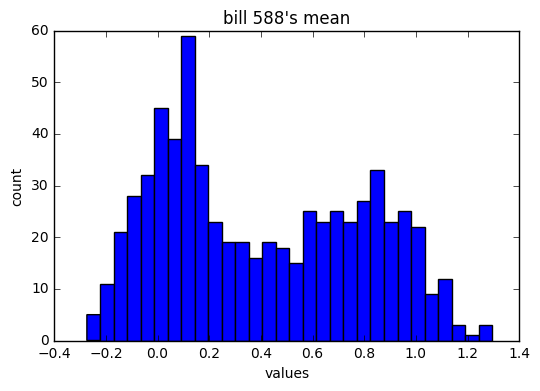

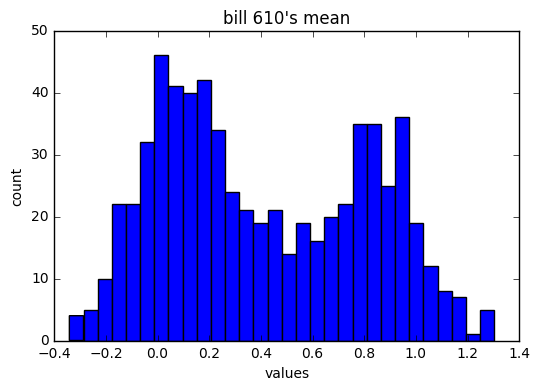

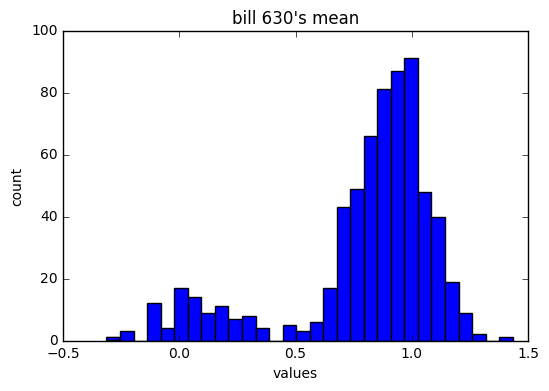

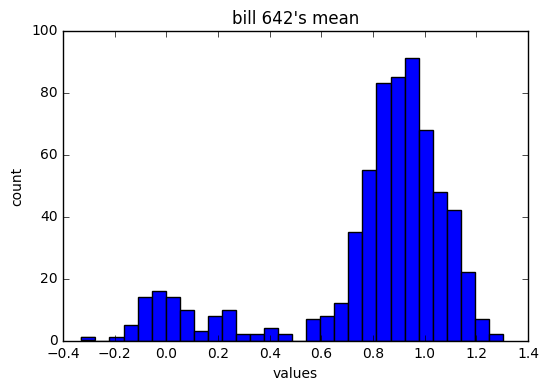

In [665]:
for i in range(n2):
    if st.uniform.rvs()<0.05:
        plt.hist(sampled_params['beta_mean'][i,0,:],bins=30)
        plt.title('bill '+str(i)+"'s mean")
        plt.ylabel('count')
        plt.xlabel('values')
        plt.show()